In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
from plot_config import *

In [3]:
from utils import *

In [4]:
# def open_case_month(which,int_arg):
#     if which == 'fresh':
#         those_slices = [427, 458, 486, 517]
#         particle_path = '/sciserver/filedb04-01/ocean/wenrui_temp/particle_file/freshM/'
#     elif which == 'salty':
#         those_slices = [122,153,184,214,245]
#         particle_path = '/sciserver/filedb08-01/ocean/wenrui_temp/particle_file/saltyM/'
#     the_slice = slice(those_slices[int_arg], those_slices[int_arg+1])
#     print(the_slice)
#     table_path = particle_path+str(the_slice)+'table/'
#     map_path = particle_path+str(the_slice)+'maps/'
#     maps = xr.open_zarr(map_path)
#     table= xr.open_zarr(table_path)
#     return maps, table

In [5]:
mmp,mtb = open_case_month('fresh',1)

/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.38.0 or higher is recommended. You are running version 2.23.0
  warnings.warn(


In [6]:
mx = open_monthly_mxld()
dep = mx.MXLDEPTH.transpose('time','face','Y','X')
seas_dep = dep.groupby('time.month').mean(dim = 'time').persist()
mean_dep = dep.mean(dim = 'time').persist()

In [7]:
ecco_grid = xr.open_zarr('~/ECCO_transport')
vol = ecco_grid.rA*ecco_grid.drF

In [8]:
import os 
for i in range(1,9):
    os.listdir(f'/sciserver/filedb0{i}-02/')
big_ecco = xr.open_mfdataset('/sciserver/filedb0*-02/ocean/poseidon/daily_mean_ecco/zarr/mean*', engine = 'zarr')

In [9]:
dail_dep = big_ecco['MXLDEPTH']
dass_dep = dail_dep.groupby('time.dayofyear').mean(dim = 'time').persist()

In [10]:
xg = np.load('plotting_xg.npy')
yg = np.load('plotting_yg.npy')

In [11]:
ali_path = '/export/scratch/asiddi24/ECCO_v4r4/eccov4r4_budgets/'
mb = xr.open_zarr(ali_path)

In [12]:
atm = xr.open_zarr('/export/scratch/wjiang33/atm_forc.zarr')

In [13]:
xc,yc = np.array(mx.XC), np.array(mx.YC)

In [14]:
imt = 277
months = 1

In [15]:
def mesh_contour(to_mesh, to_contour, ax,
                 mvmax = 1e2,
                 mesh_cmap = balance,
                 cvmax = 200,
                 clevels = 7,
                 ccolor = 'grey',
                 cont_cmap = cmocean.cm.deep,
                 level_type = 'negative',
                 colorbar_label = r'$PSU\cdot m$'
                ):
    extent = (-95, 15, 30, 65)
    ax.set_extent(extent)
    n = 20
    aoi = mpath.Path(
        list(zip(np.linspace(extent[0],extent[1], n), np.full(n, extent[3]))) + \
        list(zip(np.full(n, extent[1]), np.linspace(extent[3], extent[2], n))) + \
        list(zip(np.linspace(extent[1], extent[0], n), np.full(n, extent[2]))) + \
        list(zip(np.full(n, extent[0]), np.linspace(extent[2], extent[3], n)))
    )
    ax.set_boundary(aoi, transform=ccrs.PlateCarree())
    if level_type == 'negative':
        levels = np.linspace(-cvmax, 0,clevels)
    else:
        levels = np.linspace(-cvmax, cvmax,clevels)

    for fc in [2,6,10]:
        ct = ax.pcolormesh(xg[fc],yg[fc],to_mesh[fc],vmax = mvmax, vmin = -mvmax,cmap = mesh_cmap,transform = ccrs.PlateCarree(),linewidth = 0,rasterized = True)
    hey = ax.tricontour(xc.ravel(),
                  yc.ravel(),
                  to_contour.ravel(),
                  levels = levels,
                  # cmap = cont_cmap,
                  colors = ccolor,
                  transform = ccrs.PlateCarree())
    # plt.clabel(hey)
    
    ax.add_feature(cfeature.LAND, zorder=10, facecolor='grey')
    plt.colorbar(ct,location = 'left',pad = 0.03,label = colorbar_label,aspect = 10,extend = 'both',shrink = 0.5)
    return ax

In [16]:
ysection = 45.760967
iy2 = np.where(yc[2,:,0]== ysection)[0][0]
ix10 = np.where(yc[10,-1,:]== ysection)[0][0]
iy10 = 75
ix2 = 15
part1 = np.arange(iy10,89)
part2 = np.arange(ix2)
n1 = len(part1)
n2 = len(part2)
fc = xr.DataArray([10 for i in range(n1)]+[2 for i in range(n2)], dims = 'sec')
iy = xr.DataArray(list(part1)+[iy2 for i in range(n2)],dims = 'sec')
ix = xr.DataArray([ix10 for i in range(n1)]+list(part2),dims = 'sec')

nsec = 10
ys = np.full(nsec, ysection)
print(xc[10,iy10,ix10],xc[2,iy2,ix2])
xs = np.linspace(xc[10,iy10,ix10],xc[2,iy2,ix2],nsec)

-52.5 -22.5


In [17]:
ys

array([45.760967, 45.760967, 45.760967, 45.760967, 45.760967, 45.760967,
       45.760967, 45.760967, 45.760967, 45.760967])

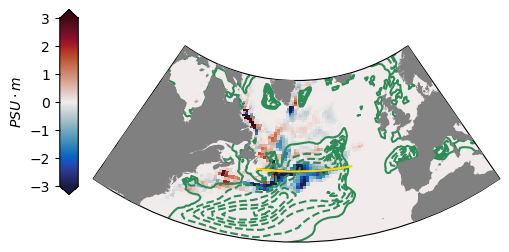

In [18]:
ax = plt.axes(projection = projection)

to_mesh = -mmp['dif_v'].sum(dim = 'Z')*VOLUME_EACH_fresh/ecco_grid.rA
to_contour = np.array((dep[imt]- seas_dep[months]).fillna(0))

mesh_contour(to_mesh, to_contour,ax,mvmax = 3,ccolor = 'seagreen',cvmax = 200,clevels = 9)

ax.plot(xs,ys,transform = ccrs.PlateCarree(),c = 'gold')

# xrange = (-48,-30)
# yrange = (40,45)
# poly = poly_from_xyrange(xrange,yrange)
# nside = 6
# xs,ys = poly.T
# xs = list(xs)+[xs[0]]
# ys = list(ys)+[ys[0]]
# for i in range(len(poly)):
#     lx = np.linspace(xs[i],xs[i+1], nside)
#     ly = np.linspace(ys[i],ys[i+1], nside)
#     # print('how')
#     ax.plot(lx,ly,transform = ccrs.PlateCarree(),c = 'gold')
# plt.savefig('figure3(a).png',dpi = dpi)

In [19]:
offset2015 = 8401
doy0 = 31
doy1 = 59
idt0 = offset2015+doy0
idt1 = offset2015+doy1

In [20]:
section = -(mmp['dif_v']/vol*VOLUME_EACH_fresh)[:,fc,iy,ix]
mb_section = mb['dif_vConvS'].transpose('time','Z','face','Y','X')[imt,:,fc,iy,ix]
count = mmp['count'][:,fc,iy,ix]/ecco_grid.drF/np.cos(ysection*np.pi/180)/111*1e3
lons = ecco_grid['XC'][fc,iy,ix]
mndep = mean_dep[fc,iy,ix]
mxdep = dep[imt,fc,iy,ix]
mxdep0 = dail_dep[idt0,fc,iy,ix]
mxdep1 = dail_dep[idt1,fc,iy,ix]
ssdep = seas_dep[months,fc,iy,ix]
ssdep0 = dass_dep[doy0,fc,iy,ix]
ssdep1 = dass_dep[doy1,fc,iy,ix]

In [21]:
count.max().values

array(22642.19044683)

In [36]:
def vertical_section(ax):
    now_color = 'cyan'
    seas_color = 'k'
    cb = plt.pcolormesh(lons, ecco_grid.Z,section,vmax = 0.05, vmin = -0.05,cmap = balance)
    ax.contour(lons,ecco_grid.Z,count,colors = 'grey',levels = np.arange(0,24000,3000))
    ml = plt.plot(lons,-mndep,color = 'r')[0]
    ax.plot(lons,-mxdep0,':',color = now_color)
    ax.plot(lons,-mxdep1,'--',color = now_color)
    bf = ax.plot(lons,-ssdep0,':',color = seas_color)[0]
    af = ax.plot(lons,-ssdep1,'--',color = seas_color)[0]
    nl = ax.plot(lons,-mxdep,now_color)[0]
    sl = ax.plot(lons,-ssdep,seas_color)[0]
    ax.set_ylim(-500,0)
    ax.set_xlim(-52.5,-23.5)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Depth (m)')
    plt.colorbar(cb,label = 'PSU',extend = 'both')
    ax.legend([ml,nl,sl,bf,af],['Climatology','Feb. 2015','Feb. Mean','1 February', '1 March'],fontsize = 7)
# plt.savefig('figure3(b).png',dpi = dpi)

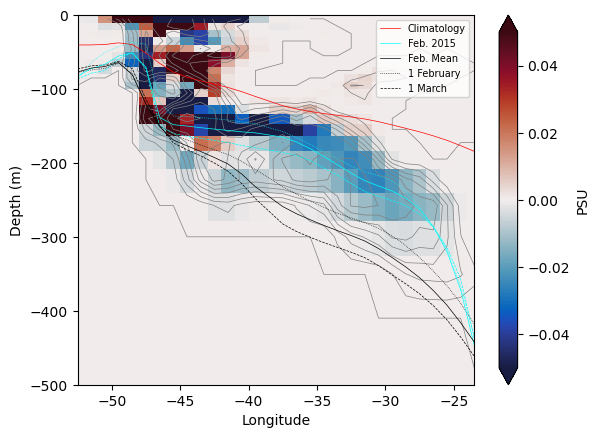

In [37]:
ax = plt.axes()
vertical_section(ax)

In [24]:
mine = '/export/scratch/wjiang33/'
mx = xr.open_zarr(mine+'mxd_monthly.zarr')
seas_dep = mx.MXLDEPTH.transpose('time','face','Y','X').groupby('time.month').mean(dim = 'time').persist()

In [25]:
rhoconst = 1029
c_p = 3994
forch = (mb['forcH']*ecco_grid.drF).sum(dim = 'Z').transpose('time','face','Y','X')*rhoconst*c_p
forc_seas = forch.groupby('time.month').mean(dim = 'time').persist()
forc_anom = forch.groupby('time.month') - forc_seas

/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]


In [26]:
wind = atm['EXFwspee']
wind_seas = wind.groupby('time.month').mean(dim = 'time').persist()
wind_anom = wind.groupby('time.month') - wind_seas

/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 26 times more chunks
  return self.array[key]


In [27]:
forc_anom[1,1,1,1].values

array(-6.25298104)

<GeoAxes: >

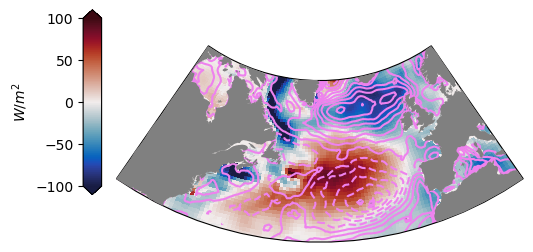

In [28]:
ax = plt.axes(projection = projection)

to_mesh = forc_anom[275:278].mean(dim = 'time')
to_contour = np.array(wind_anom[275:278].mean(dim = 'time').fillna(0))

mesh_contour(to_mesh, to_contour,ax,mvmax = 100, cvmax = 3,level_type = 'both',clevels = 17,colorbar_label = r'$W/m^2$',ccolor = 'violet')



# plt.savefig('figure3(c).png',dpi = dpi)

In [29]:
mm = 1/25.4
plt.rcParams['lines.linewidth'] = 0.5

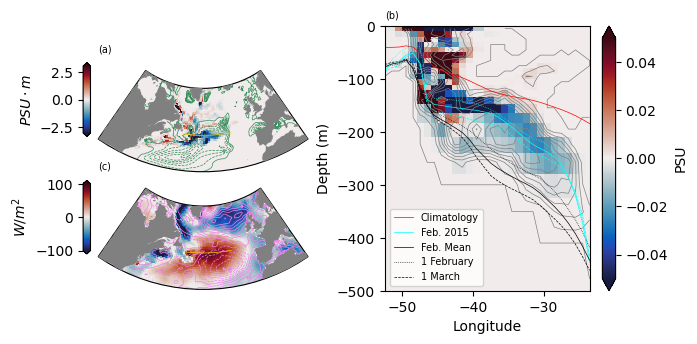

In [38]:
fig = plt.figure(figsize = (180*mm,90*mm))
ax1 = plt.subplot(2,2,1,projection = projection)
ax1.set_title('(a)',loc = 'left',fontsize = 7)

to_mesh = -mmp['dif_v'].sum(dim = 'Z')*VOLUME_EACH_fresh/ecco_grid.rA
to_contour = np.array((dep[imt]- seas_dep[months]).fillna(0))
mesh_contour(to_mesh, to_contour,ax1,mvmax = 3,ccolor = 'seagreen',cvmax = 200,clevels = 9)

ax2 = plt.subplot(2,2,3,projection = projection)
ax2.set_title('(c)',loc = 'left',fontsize = 7)
to_mesh = forc_anom[275:278].mean(dim = 'time')
to_contour = np.array(wind_anom[275:278].mean(dim = 'time').fillna(0))

mesh_contour(to_mesh, to_contour,ax2,mvmax = 100, cvmax = 3,level_type = 'both',clevels = 17,colorbar_label = r'$W/m^2$',ccolor = 'violet')

for ax in [ax1,ax2]:
    ax.plot(xs,ys,transform = ccrs.PlateCarree(),c = 'gold')

ax = plt.subplot(1,2,2)
vertical_section(ax)
ax.set_title('(b)',loc = 'left',fontsize = 7)

plt.tight_layout()
plt.subplots_adjust(hspace = -0.2,wspace = 0.3)

plt.savefig('vert_diff_exp.pdf',dpi = 300)

In [31]:
# ax = plt.axes(projection = projection)
# xrange = (-48,-30)
# yrange = (40,45)
# poly = poly_from_xyrange(xrange,yrange)
# nside = 6
# xs,ys = poly.T
# xs = list(xs)+[xs[0]]
# ys = list(ys)+[ys[0]]
# for i in range(len(poly)):
#     lx = np.linspace(xs[i],xs[i+1], nside)
#     ly = np.linspace(ys[i],ys[i+1], nside)
#     # print('how')
#     ax.plot(lx,ly,transform = ccrs.PlateCarree(),c = 'gold')

# Comparison with ORAS5

In [32]:
# those = np.where(
#     np.logical_and(
#         np.logical_and(xrange[0]<xc,xrange[1]>xc),
#         np.logical_and(yrange[0]<yc,yrange[1]>yc)
#     )
# )

# sfc,siy,six = [xr.DataArray(i, dims = 'to_sum') for i in those]

# actual_area = float(ecco_grid.rA[sfc,siy,six].sum())

# event_slice = slice(imt- 3,imt+3)
# ttt = atm.time[event_slice]
# seas_slice = np.arange(imt+100)[event_slice] - imt+months

# forch_ts = (forch*ecco_grid.rA/actual_area)[:,sfc,siy,six].sum(dim = 'to_sum').persist()
# wind_ts = (wind*ecco_grid.rA/actual_area)[:,sfc,siy,six].sum(dim = 'to_sum').persist()
# mix_ts = (dep*ecco_grid.rA/actual_area)[:,sfc,siy,six].sum(dim = 'to_sum').persist()

# seas_h = forch_ts.groupby('time.month').mean('time')
# seas_w = wind_ts.groupby('time.month').mean('time')
# seas_m = mix_ts.groupby('time.month').mean('time')

# std_h = forch_ts.groupby('time.month').std('time')
# std_w = wind_ts.groupby('time.month').std('time')
# std_m = mix_ts.groupby('time.month').std('time')

# oras5_path = '/export/scratch/wjiang33/oras5/'
# opa = 0
# specific = oras5_path+'mxl'+f'/opa{opa}/'
# files = [specific+i for i in sorted(os.listdir(specific))]

# datasets = [xr.open_dataset(file) for file in files]

# ds = xr.concat(datasets, dim = 'time_counter')

# oras_those = np.where(
#     np.logical_and(
#         np.logical_and(xrange[0]<ds.nav_lon,xrange[1]>ds.nav_lon),
#         np.logical_and(yrange[0]<ds.nav_lat,yrange[1]>ds.nav_lat)
#     )
# )

# oras_those[0].size

# oiy,oix = [xr.DataArray(i, dims = 'to_sum') for i in oras_those]

# oras_mix_ts = ds['somxl010'][:,oiy,oix].mean(dim = 'to_sum')

# oras_seas_m = oras_mix_ts.groupby('time_counter.month').mean('time_counter')

# oras5_path = '/export/scratch/wjiang33/oras5/'
# opa = 0
# specific = oras5_path+'tflux'+f'/opa{opa}/'
# files = [specific+i for i in sorted(os.listdir(specific))]

# datasets = [xr.open_dataset(file) for file in files]

# ds = xr.concat(datasets, dim = 'time_counter')

# oras_tflux_ts = ds['sohefldo'][:,oiy,oix].mean(dim = 'to_sum')
# oras_seas_h = oras_tflux_ts.groupby('time_counter.month').mean('time_counter')

# varu = 'windU'
# varnameu = 'sozotaux'
# varv = 'windV'
# varnamev = 'sometauy'

# specificu = oras5_path+varu+f'/opa{opa}/'
# filesu = [specificu+i for i in sorted(os.listdir(specificu))]
# datasetsu = [xr.open_dataset(file) for file in filesu]
# dsu = xr.concat(datasetsu, dim = 'time_counter')

# specificv = oras5_path+varv+f'/opa{opa}/'
# filesv = [specificv+i for i in sorted(os.listdir(specificv))]
# datasetsv = [xr.open_dataset(file) for file in filesv]
# dsv = xr.concat(datasetsv, dim = 'time_counter')

# windu = 0.5*(dsu[varnameu][:,1:,1:]+dsu[varnameu][:,1:,:-1])
# windv = 0.5*(dsv[varnamev][:,1:,1:]+dsv[varnamev][:,:-1,1:])

# dsv['wind'] = xr.DataArray(np.hypot(windu.data,windv.data),dims = ('time_counter','ym1','xm1'))

# oras_wind_ts = dsv['wind'][:,oiy-1,oix-1].mean(dim = 'to_sum')

# oras_seas_w = oras_wind_ts.groupby('time_counter.month').mean('time_counter')

# seas_ls = '--'
# oras_c = 'r'
# ecco_c = 'k'

# plt.plot(ttt,forch_ts[event_slice],c = ecco_c,label = 'ECCO')
# plt.plot(ttt,seas_h[seas_slice],c = ecco_c,ls = seas_ls,label = 'Seasonal Average')
# plt.fill_between(ttt,seas_h[seas_slice]-std_h[seas_slice],seas_h[seas_slice]+std_h[seas_slice],alpha = 0.1,color = ecco_c)

# plt.plot(ttt,oras_tflux_ts[event_slice],c = oras_c,label = 'ORAS5')
# plt.plot(ttt,oras_seas_h[seas_slice],c = oras_c,ls = seas_ls)

# plt.ylabel(r'$W/m^2$')
# plt.legend()
# plt.title('Heat Flux')
# plt.savefig('sup_figure3(b).png',dpi = dpi)
# # plt.plot([imt, imt],[-10000,10000],alpha = 0.3)

# a = plt.plot(ttt,wind_ts[event_slice],c = ecco_c,label = 'ECCO')[0]
# b = plt.plot(ttt,seas_w[seas_slice],c = ecco_c,ls = seas_ls,label = 'Seasonal Average')[0]
# plt.fill_between(ttt,seas_w[seas_slice]-std_w[seas_slice],seas_w[seas_slice]+std_w[seas_slice],alpha = 0.1,color = ecco_c)
# plt.ylabel(r'$m^2/s^2$')

# axx = plt.twinx(plt.gca())

# c=axx.plot(ttt,oras_wind_ts[event_slice],c = oras_c)[0]
# axx.plot(ttt,oras_seas_w[seas_slice],c = oras_c,ls = seas_ls)
# axx.set_ylabel(r'$N/m^2$',color = oras_c)
# axx.spines['right'].set_color(oras_c)
# axx.tick_params(axis='y', colors=oras_c)
# plt.legend([a,b,c],['ECCO','Seasonal Average','ORAS5'])
# plt.title('Wind speed and stress')
# plt.savefig('sup_figure3(c).png',dpi = dpi)
# # plt.plot([imt, imt],[-10000,10000],alpha = 0.3)

# plt.plot(ttt,mix_ts[event_slice],c = ecco_c,label = 'ECCO')
# plt.plot(ttt,seas_m[seas_slice],c = ecco_c,ls = seas_ls,label = 'Seasonal Average')
# plt.fill_between(ttt,seas_m[seas_slice]-std_m[seas_slice],seas_m[seas_slice]+std_m[seas_slice],alpha = 0.1,color = ecco_c)

# plt.plot(ttt,oras_mix_ts[event_slice],c = oras_c,label = 'ORAS5')
# plt.plot(ttt,oras_seas_m[seas_slice],c = oras_c,ls = seas_ls)
# # plt.plot([imt, imt],[-10000,10000],alpha = 0.3)

# plt.ylabel(r'm$')
# plt.legend()
# plt.title('Mixed Layer Depth')
# plt.savefig('sup_figure3(a).png',dpi = dpi)